In [ ]:
%pip install pandas numpy matplotlib pyarrow fastparquet  # (uncomment if needed)

import os, re, glob
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 60)

In [3]:
# - PATHS 
ACTUALS_CSV = "/home/renga/Desktop/data_neoen/data/measurements_neoen_morcenx_sep2025.csv"   # put full path if not in CWD
FORECAST_DIR = Path("/home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx")

#  FORECAST FILE NAMING 
# Example: forecast_202510070515.csv  -> run time = 2025-10-07 05:15 UTC
FC_PATTERN = "forecast_*.csv"
FC_TS_REGEX = re.compile(r"forecast_(\d{12})\.csv")  # captures YYYYMMDDHHMM

#  COLUMN NAMES  
ACTUALS_TIME_COL = "measure_date"
ACTUALS_PROD_COL = "prod"  # we're focusing on production

FC_TARGET_COL = "horizon"      # tz-aware UTC timestamps like '2025-07-07 14:15:00+00:00'
FC_DET_COL    = "deterministic"
FC_CLEAR_SKY  = "clear_sky"

# Quantiles we’ll read from forecast files
FC_QUANT_COLS = [
    "p_05","p_10","p_15","p_20","p_25","p_30","p_35","p_40","p_45",
    "p_50","p_55","p_60","p_65","p_70","p_75","p_80","p_85","p_90","p_95"
]

# Convenience subsets
FC_P10_COL, FC_P50_COL, FC_P90_COL = "p_10", "p_50", "p_90"

# Analysis window for actuals (optional, speeds things up). Use UTC date strings.
DATE_MIN = None  # e.g., "2025-09-01"
DATE_MAX = None  # e.g., "2025-09-30"


In [4]:
# Helper: turn a user selection (e.g., 10 or [5, 10, 50, 90]) into valid column names.
def normalize_p_selection(p_selection):
    """
    Accepts: int/float (e.g., 10), str ('p_10' or '10'), or list/tuple of those.
    Returns: (col_names, pretty_labels) where:
      col_names like ['p_10','p_50'], pretty_labels like ['p10','p50']
    """
    if p_selection is None:
        return [], []

    def to_col(x):
        if isinstance(x, (int, float)):
            v = int(round(x))
            return f"p_{v:02d}"
        s = str(x).strip().lower()
        if s.startswith("p_"):
            return s
        # '10' -> 'p_10'
        return f"p_{int(round(float(s))):02d}"

    if isinstance(p_selection, (list, tuple, set)):
        cols = [to_col(v) for v in p_selection]
    else:
        cols = [to_col(p_selection)]

    # de-dup while preserving order and keep only those that actually exist in your files config
    seen, cols_ok = set(), []
    for c in cols:
        if c in seen: 
            continue
        if c not in FC_QUANT_COLS:
            print(f"[warn] Requested quantile '{c}' not in available columns; skipping.")
            continue
        seen.add(c)
        cols_ok.append(c)

    labels = [c.replace("p_", "p") for c in cols_ok]  # 'p_10' -> 'p10'
    return cols_ok, labels


In [5]:
actuals = pd.read_csv(ACTUALS_CSV, parse_dates=[ACTUALS_TIME_COL])

# Ensure tz-aware UTC (your sample already is, but this keeps it robust)
if actuals[ACTUALS_TIME_COL].dtype.tz is None:
    actuals[ACTUALS_TIME_COL] = actuals[ACTUALS_TIME_COL].dt.tz_localize("UTC")
else:
    # Normalize to UTC in case it’s another tz (unlikely given +00:00)
    actuals[ACTUALS_TIME_COL] = actuals[ACTUALS_TIME_COL].dt.tz_convert("UTC")

# Optional date window
if DATE_MIN:
    actuals = actuals[actuals[ACTUALS_TIME_COL] >= pd.to_datetime(DATE_MIN, utc=True)]
if DATE_MAX:
    actuals = actuals[actuals[ACTUALS_TIME_COL] <= pd.to_datetime(DATE_MAX, utc=True)]

# --- Keep only exact 15-minute grid points (…:00, :15, :30, :45) ---
# This is a strict filter (no averaging), matching your forecast cadence.
mask_15 = (
    (actuals[ACTUALS_TIME_COL].dt.minute % 15 == 0) &
    (actuals[ACTUALS_TIME_COL].dt.second == 0) &
    (actuals[ACTUALS_TIME_COL].dt.microsecond == 0)
)
actuals_15 = actuals.loc[mask_15].copy()

# Keep only time + prod (adjust if you need more columns later)
actuals_15 = actuals_15[[ACTUALS_TIME_COL, ACTUALS_PROD_COL]].sort_values(ACTUALS_TIME_COL).reset_index(drop=True)

display(actuals_15.head(8))
# print("Actual rows at 15-min cadence:", len(actuals_15))


,measure_date,prod
0,2025-09-01 00:00:00+00:00,0.0
1,2025-09-01 00:15:00+00:00,0.0
2,2025-09-01 00:30:00+00:00,0.0
3,2025-09-01 00:45:00+00:00,0.0
4,2025-09-01 01:00:00+00:00,0.0
5,2025-09-01 01:15:00+00:00,0.0
6,2025-09-01 01:30:00+00:00,0.0
7,2025-09-01 01:45:00+00:00,0.0


In [6]:
def run_time_to_filename(run_ts_utc: pd.Timestamp) -> Path:
    """Make forecast filename from a UTC run timestamp (rounded to 15 min)."""
    if run_ts_utc.tz is None:
        run_ts_utc = run_ts_utc.tz_localize("UTC")
    ts_str = run_ts_utc.strftime("%Y%m%d%H%M")  # YYYYMMDDHHMM
    return FORECAST_DIR / f"forecast_{ts_str}.csv"

def filename_to_run_time(path: Path) -> pd.Timestamp:
    m = FC_TS_REGEX.match(path.name)
    if not m:
        raise ValueError(f"Unexpected forecast filename: {path.name}")
    ts = datetime.strptime(m.group(1), "%Y%m%d%H%M")
    return pd.Timestamp(ts, tz="UTC")

def safe_read_forecast(path: Path, usecols=None) -> pd.DataFrame | None:
    """Read a forecast CSV, or return None if missing/empty/bad."""
    if not path.exists():
        return None
    try:
        df = pd.read_csv(path, parse_dates=[FC_TARGET_COL], usecols=usecols)
        # Ensure target is tz-aware UTC; if not, localize (adjust if they’re local)
        if df[FC_TARGET_COL].dtype.tz is None:
            df[FC_TARGET_COL] = df[FC_TARGET_COL].dt.tz_localize("UTC")
        return df
    except Exception as e:
        print(f"Warning: skipping {path.name}: {e}")
        return None


In [7]:
def collect_forecasts_for_target(target_ts_utc: pd.Timestamp) -> pd.DataFrame:
    """
    For a given target timestamp (UTC), fetch the predictions for that target
    from all run files whose forecast horizon includes the target (last 48h).
    Returns a tidy DataFrame: one row per run_time with deterministic, clear_sky, quantiles, and lead_hours.
    """
    if target_ts_utc.tz is None:
        target_ts_utc = target_ts_utc.tz_localize("UTC")

    run_start = target_ts_utc - pd.Timedelta(hours=48)
    run_times = pd.date_range(run_start, target_ts_utc, freq="15min", tz="UTC")

    rows = []
    usecols = [FC_TARGET_COL, FC_DET_COL, FC_CLEAR_SKY] + FC_QUANT_COLS

    for run_ts in run_times:
        path = run_time_to_filename(run_ts)
        df = safe_read_forecast(path, usecols=usecols)
        if df is None or df.empty:
            continue

        # Extract the row where horizon equals our target time
        # (exact match; if your CSV timestamps differ in rounding, consider a tolerance)
        matched = df.loc[df[FC_TARGET_COL] == target_ts_utc]
        if matched.empty:
            continue

        row = matched.iloc[0].to_dict()
        row["run_time"] = run_ts
        row["target_time"] = target_ts_utc
        row["lead_hours"] = (target_ts_utc - run_ts).total_seconds() / 3600.0
        rows.append(row)

    if not rows:
        return pd.DataFrame(columns=["run_time","target_time","lead_hours", FC_DET_COL, FC_CLEAR_SKY] + FC_QUANT_COLS)

    out = pd.DataFrame(rows).sort_values("run_time").reset_index(drop=True)
    return out


In [8]:
# Manually set your target timestamp (must exist in actuals_15) ---

# Example: paste the exact timestamp from your data (UTC, tz-aware).
TARGET_TS_STR = "2025-09-11 13:45:00+00:00"  # <- change this

TARGET_TS = pd.to_datetime(TARGET_TS_STR, utc=True)

# Validate it exists in actuals_15
if not (actuals_15[ACTUALS_TIME_COL] == TARGET_TS).any():
    # Show a hint of nearby options if not found
    print(f"[Warning] {TARGET_TS} not found in actuals_15.")
    # Suggest the closest available timestamp
    diffs = (actuals_15[ACTUALS_TIME_COL] - TARGET_TS).abs()
    closest_idx = diffs.argmin()
    print("Closest available:", actuals_15.loc[closest_idx, ACTUALS_TIME_COL])

print("Target timestamp:", TARGET_TS)

fc_target = collect_forecasts_for_target(TARGET_TS)
display(fc_target.head(172))
print("Forecast runs found:", len(fc_target), "(expected up to 192 if all files exist)")


Target timestamp: 2025-09-11 13:45:00+00:00


,horizon,p_05,p_10,p_15,p_20,p_25,p_30,p_35,p_40,p_45,p_50,p_55,p_60,p_65,p_70,p_75,p_80,p_85,p_90,p_95,clear_sky,deterministic,run_time,target_time,lead_hours
0,2025-09-11 13:45:00+00:00,759.512523,1018.176582,1319.983291,1643.576144,1970.451930,2276.894009,2701.819559,3019.594144,3462.417148,3847.096077,4144.524065,4510.446364,5568.583507,6327.891273,7637.079352,8961.819185,10529.960310,12276.629483,13140.041932,12769.921482,4942.914018,2025-09-09 13:45:00+00:00,2025-09-11 13:45:00+00:00,48.00
1,2025-09-11 13:45:00+00:00,719.048388,952.388194,1265.957538,1615.699000,1954.659664,2268.639218,2647.995360,2918.597280,3213.910182,3709.178079,3992.002219,4447.545194,5502.888197,6425.719581,7822.880847,9092.629964,10586.199892,12259.038207,13065.098777,12733.163882,4899.623436,2025-09-09 14:15:00+00:00,2025-09-11 13:45:00+00:00,47.50
2,2025-09-11 13:45:00+00:00,663.472295,996.769118,1277.015016,1538.628678,2009.864951,2223.324566,2665.796121,2940.322767,3261.943609,3822.710279,4122.387881,4478.489638,5666.670097,6820.268586,7978.772395,9193.694581,10683.470390,12301.540383,13157.644209,12733.163882,4966.295946,2025-09-09 14:30:00+00:00,2025-09-11 13:45:00+00:00,47.25
3,2025-09-11 13:45:00+00:00,293.735128,553.847746,747.211473,996.532161,1242.098462,1613.159481,1772.304550,2169.772625,2507.551172,2832.089576,3312.540745,3625.115796,4983.904622,5496.218225,7390.031327,8766.510938,11008.330895,12445.307867,12908.892598,12733.163882,4167.130725,2025-09-09 14:45:00+00:00,2025-09-11 13:45:00+00:00,47.00
4,2025-09-11 13:45:00+00:00,172.334594,434.089514,578.608596,841.302630,1090.779688,1482.653029,1705.338767,2081.319899,2460.710583,2879.154841,3234.558635,3781.312929,4985.288950,6209.312960,8006.327678,9183.406987,11246.255776,12378.854053,12816.971585,12733.163882,4183.324134,2025-09-09 15:00:00+00:00,2025-09-11 13:45:00+00:00,46.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2025-09-11 13:45:00+00:00,964.606048,1292.338246,1613.428017,1801.916980,2022.499007,2270.011099,2490.932676,2659.864643,2826.302485,3155.186193,3532.550819,4105.122799,4523.618658,5156.274723,5478.804017,5924.262463,6890.777946,9127.866685,12013.476098,12852.648443,4085.744747,2025-09-11 11:15:00+00:00,2025-09-11 13:45:00+00:00,2.50
168,2025-09-11 13:45:00+00:00,457.184166,760.419494,940.353584,1075.042873,1173.367551,1271.291983,1374.041293,1559.892642,1679.795256,1874.259946,2014.760645,2228.721946,2444.469907,2714.731959,2958.619487,3217.387675,3821.972368,4480.212410,5993.863252,12852.648443,2448.728130,2025-09-11 11:30:00+00:00,2025-09-11 13:45:00+00:00,2.25
169,2025-09-11 13:45:00+00:00,670.538787,1045.186412,1300.957877,1433.284865,1700.744691,1898.823199,2070.308213,2191.694546,2399.271194,2587.750566,2788.449332,2983.793504,3172.030466,3441.443624,3800.182568,4273.094942,5008.618102,5777.307796,7879.658208,12852.648443,3042.094699,2025-09-11 11:45:00+00:00,2025-09-11 13:45:00+00:00,2.00
170,2025-09-11 13:45:00+00:00,53.560346,744.816970,1354.491034,1568.416121,2046.392847,2420.597874,2718.687916,3017.291452,3324.094916,3596.431023,3987.675362,4386.267749,5013.937301,5604.900614,6440.010425,7348.497971,8558.593143,9911.790850,11839.852990,12852.648443,4338.380141,2025-09-11 12:00:00+00:00,2025-09-11 13:45:00+00:00,1.75


Forecast runs found: 177 (expected up to 192 if all files exist)


In [ ]:
# Configurable errors per run + MAE/RMSE summaries

#   User selection -
INCLUDE_DET = True           # compare deterministic?
INCLUDE_CLEAR_SKY = False    # compare clear_sky as well?
P_SELECTION = [30,40,50,60,70]   # choose any single value (e.g., 35) or list like [5,10,20,50,80,90]

# Build the list of forecast columns to evaluate
p_cols, p_labels = normalize_p_selection(P_SELECTION)

forecast_cols = []
labels_map = {}   # column_name -> pretty label for plots/tables

if INCLUDE_DET:
    forecast_cols.append(FC_DET_COL); labels_map[FC_DET_COL] = "deterministic"
if INCLUDE_CLEAR_SKY:
    forecast_cols.append(FC_CLEAR_SKY); labels_map[FC_CLEAR_SKY] = "clear_sky"

for c, lab in zip(p_cols, p_labels):
    forecast_cols.append(c); labels_map[c] = lab

# 0) Actual value at target
actual_value = float(
    actuals_15.loc[actuals_15[ACTUALS_TIME_COL] == TARGET_TS, ACTUALS_PROD_COL].iloc[0]
)

# 1) Build tidy table (one row per run_time × forecast series)
cols_needed = ["run_time", "lead_hours"] + forecast_cols
long = (
    fc_target[cols_needed]
      .melt(id_vars=["run_time", "lead_hours"],
            var_name="forecast_col", value_name="forecast_value")
      .sort_values(["lead_hours", "forecast_col"], ascending=[False, True])
      .reset_index(drop=True)
)

# 2) Map to clean names (e.g., p_50 -> p50)
clean_name = long["forecast_col"].map(labels_map)
long["forecast_type"] = clean_name.fillna(long["forecast_col"].str.replace("p_", "p", regex=False))

# 3) Errors vs actual
long["actual_value"]  = actual_value
long["error"] = (long["forecast_value"] - long["actual_value"]).where(
    long["actual_value"].notna()
    & long["actual_value"].ne(0.0)
    & long["actual_value"].ne(long["actual_value"].shift())
)
long["abs_error"]     = long["error"].abs()
long["squared_error"] = long["error"] ** 2

# 4) Final summary view with requested columns
per_run_summary = (
    long[["run_time", "lead_hours", "forecast_type",
          "actual_value", "forecast_value", "error", "abs_error", "squared_error"]]
    .sort_values(["lead_hours", "forecast_type"], ascending=[False, True])
    .reset_index(drop=True)
)

print(f"Target timestamp: {TARGET_TS}   |   Actual prod at target:{actual_value:,.3f}")
print("Comparing forecast series:", [labels_map[c] for c in forecast_cols])
print(f"Rows: {len(per_run_summary)}  (≈ number_of_runs × number_of_selected_series)")
per_run_summary = per_run_summary.sort_values("run_time")
display(per_run_summary.tail(48))

# display(per_run_summary.head(1032))

# OPTIONAL: quick overall metrics by forecast_type (keep if useful)
summary_metrics = (
    per_run_summary.groupby("forecast_type", as_index=False)
                   .agg(n=("error","size"),
                        MAE=("abs_error","mean"),
                        RMSE=("squared_error", lambda s: (s.mean())**0.5),
                        Bias=("error","mean"))
                   .sort_values("MAE")
)
display(summary_metrics)

# OPTIONAL: save to CSV for this target
# out_name = f"per_run_summary_{str(TARGET_TS).replace(':','').replace(' ','_')}.csv"
# per_run_summary.to_csv(out_name, index=False)
# print("Saved:", out_name)


Target timestamp: 2025-09-11 13:45:00+00:00   |   Actual prod at target:0.000
Comparing forecast series: ['deterministic', 'p30', 'p40', 'p50', 'p60', 'p70']
Rows: 1062  (≈ number_of_runs × number_of_selected_series)


,run_time,lead_hours,forecast_type,actual_value,forecast_value,error,abs_error,squared_error
1014,2025-09-11 11:45:00+00:00,2.00,deterministic,0.0,3042.094699,NaN,NaN,NaN
1015,2025-09-11 11:45:00+00:00,2.00,p30,0.0,1898.823199,NaN,NaN,NaN
1016,2025-09-11 11:45:00+00:00,2.00,p40,0.0,2191.694546,NaN,NaN,NaN
1017,2025-09-11 11:45:00+00:00,2.00,p50,0.0,2587.750566,NaN,NaN,NaN
1018,2025-09-11 11:45:00+00:00,2.00,p60,0.0,2983.793504,NaN,NaN,NaN
1019,2025-09-11 11:45:00+00:00,2.00,p70,0.0,3441.443624,NaN,NaN,NaN
1025,2025-09-11 12:00:00+00:00,1.75,p70,0.0,5604.900614,NaN,NaN,NaN
1024,2025-09-11 12:00:00+00:00,1.75,p60,0.0,4386.267749,NaN,NaN,NaN
1023,2025-09-11 12:00:00+00:00,1.75,p50,0.0,3596.431023,NaN,NaN,NaN
1020,2025-09-11 12:00:00+00:00,1.75,deterministic,0.0,4338.380141,NaN,NaN,NaN


,forecast_type,n,MAE,RMSE,Bias
0,deterministic,177,NaN,NaN,NaN
1,p30,177,NaN,NaN,NaN
2,p40,177,NaN,NaN,NaN
3,p50,177,NaN,NaN,NaN
4,p60,177,NaN,NaN,NaN
5,p70,177,NaN,NaN,NaN


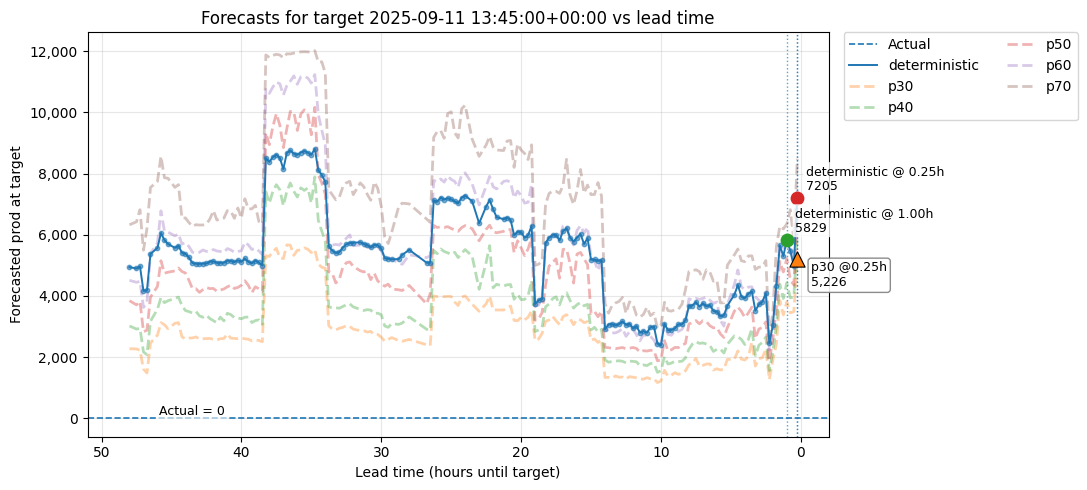

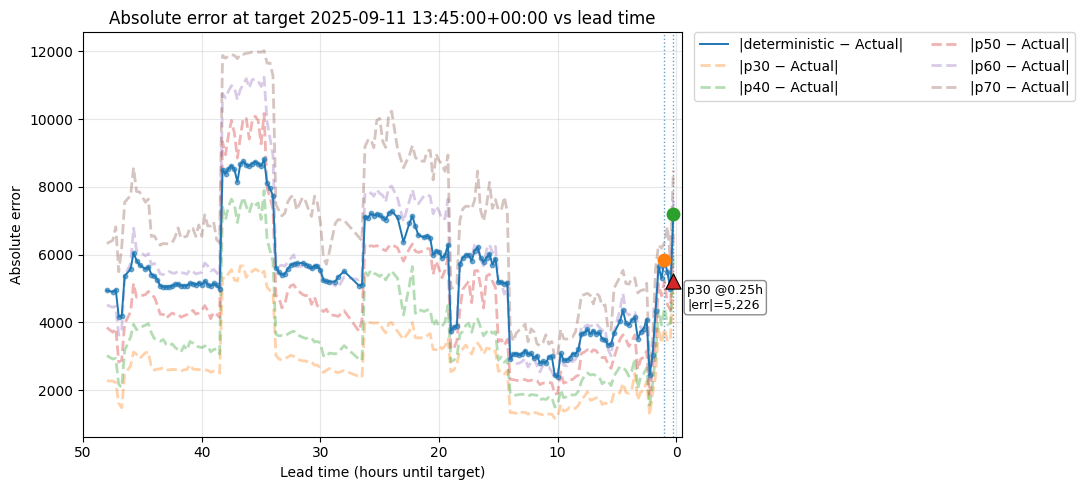

In [32]:
# forecasts vs lead time with clearer highlights & annotations -
import matplotlib.ticker as mtick

# Choose what to HIGHLIGHT (subset of forecast_cols)
# e.g., highlight det + p50 + p90
HIGHLIGHT_DET = True
HIGHLIGHT_CLEAR_SKY = False
HIGHLIGHT_P = []  # will intersect with what's actually in forecast_cols
hi_p_cols, _ = normalize_p_selection(HIGHLIGHT_P)

highlight_cols = set()
if HIGHLIGHT_DET and ("deterministic" in labels_map.values()):
    highlight_cols.add(FC_DET_COL)
if HIGHLIGHT_CLEAR_SKY and ("clear_sky" in labels_map.values()):
    highlight_cols.add(FC_CLEAR_SKY)
highlight_cols.update(set(hi_p_cols) & set(forecast_cols))

df_plot = fc_target.copy()
actual_val = float(actuals_15.loc[actuals_15[ACTUALS_TIME_COL] == TARGET_TS, ACTUALS_PROD_COL].iloc[0])

# Vertical markers to emphasize 1h and 15m before target
marker_targets = [1.0, 0.25]   # hours

# ---------- Forecasted value plot ----------
fig, ax = plt.subplots(figsize=(11,5))

# Right gutter so annotations at the near-0 side have room
x_max = float(df_plot["lead_hours"].max())
ax.set_xlim(x_max + 1, -0.5)   # inverted axis + 2h pad on the left, 0.5h pad on the right

# Actual line
ax.axhline(actual_val, linestyle="--", linewidth=1.2, label="Actual")
val_str = f"{actual_val:,.0f}"

ax.annotate(f"Actual = {val_str}",
            xy=(0.185, actual_val),                 # x=98.5% across, y=actual_val
            xycoords=('axes fraction', 'data'),
            ha='right', va='bottom',
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.6))

# Vertical reference lines
for lt in marker_targets:
    ax.axvline(lt, linestyle=":", linewidth=1, alpha=0.7)

# Plot all selected series; highlight chosen ones
for col in forecast_cols:
    label = labels_map[col]
    is_hi = col in highlight_cols
    lw = 1.4 if is_hi else 2.0
    alpha = 1.0 if is_hi else 0.35
    ls = "-" if is_hi else "--"
    ax.plot(df_plot["lead_hours"], df_plot[col], label=label, linewidth=lw, alpha=alpha, linestyle=ls, zorder=3 if is_hi else 2)
    if is_hi:
        ax.scatter(df_plot["lead_hours"], df_plot[col], s=10, alpha=0.6, zorder=4)

# Optional p10–p90 band if both are present (kept faint)
if ("p_10" in forecast_cols) and ("p_90" in forecast_cols):
    ax.fill_between(df_plot["lead_hours"], df_plot["p_10"], df_plot["p_90"], alpha=0.15, label="p10–p90 band", zorder=1)

# find nearest row to 0.25h
row025 = df_plot.iloc[(df_plot["lead_hours"] - 0.25).abs().idxmin()]

# pick the best p_* at that single point
p_cols_present = [c for c in forecast_cols if c.startswith("p_")]
errors_025 = {
    c: abs(float(row025[c]) - float(actual_val))
    for c in p_cols_present
    if pd.notna(row025[c])
}
if errors_025:
    best_col = min(errors_025, key=errors_025.get)
    best_label = labels_map.get(best_col, best_col.replace("p_", "p"))
    best_val = float(row025[best_col])

    # optional guide line at T−15m
    ax.axvline(0.25, linestyle=":", linewidth=1, alpha=0.7)

    # single highlighted marker + label
    ax.scatter([row025["lead_hours"]],[best_val],
               s=120, marker="^", edgecolor="k", linewidths=0.8, zorder=6)
    ax.annotate(f"{best_label} @0.25h\n{best_val:,.0f}",
                (row025["lead_hours"], best_val),
                textcoords="offset points", xytext=(10,-20),
                bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9),
                fontsize=9, zorder=7, clip_on=False)


# Annotations for highlighted series at T−1h and T−15m
for lt in marker_targets:
    row = df_plot.iloc[(df_plot["lead_hours"] - lt).abs().idxmin()]
    for col in highlight_cols:
        y = float(row[col])
        ax.scatter([row["lead_hours"]], [y], s=80, zorder=5)
        ax.annotate(
            f"{labels_map[col]} @ {row['lead_hours']:.2f}h\n{y:.0f}",
            (row["lead_hours"], y),
            textcoords="offset points",
            xytext=(6,6),
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8),
            zorder=6,
            clip_on=False
        )

x_max = float(df_plot["lead_hours"].max())
ax.set_xlim(x_max + 3.0, -2.0)   # <<< bigger gutter: +4h on the left, 1h on the right
ax.autoscale(False)

ax.set_xlabel("Lead time (hours until target)")
ax.set_ylabel("Forecasted prod at target")
ax.set_title(f"Forecasts for target {TARGET_TS} vs lead time")

# Format y with thousands separators (no units change)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

# Legend outside to avoid covering lines
ax.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- Absolute error plot (mirrors styling) ----------
fig, ax = plt.subplots(figsize=(11,5))
ax.set_xlim(x_max + 2, -0.5)
for lt in marker_targets:
    ax.axvline(lt, linestyle=":", linewidth=1, alpha=0.7)

for col in forecast_cols:
    label = labels_map[col]
    is_hi = col in highlight_cols
    series = (df_plot[col] - actual_val).abs()
    lw = 1.4 if is_hi else 2.0
    alpha = 1.0 if is_hi else 0.35
    ls = "-" if is_hi else "--"
    ax.plot(df_plot["lead_hours"], series, label=f"|{label} − Actual|", linewidth=lw, alpha=alpha, linestyle=ls, zorder=3 if is_hi else 2)
    if is_hi:
        ax.scatter(df_plot["lead_hours"], series, s=10, alpha=0.6, zorder=4)

for lt in marker_targets:
    row = df_plot.iloc[(df_plot["lead_hours"] - lt).abs().idxmin()]
    for col in highlight_cols:
        y = abs(float(row[col]) - actual_val)
        ax.scatter([row["lead_hours"]], [y], s=80, zorder=5)

best_err = abs(best_val - float(actual_val))
ax.scatter([row025["lead_hours"]],[best_err],
           s=120, marker="^", edgecolor="k", linewidths=0.8, zorder=6)
ax.annotate(f"{best_label} @0.25h\n|err|={best_err:,.0f}",
            (row025["lead_hours"], best_err),
            textcoords="offset points", xytext=(10,-20),
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9),
            fontsize=9, zorder=7, clip_on=False)


ax.set_xlabel("Lead time (hours until target)")
ax.set_ylabel("Absolute error")
ax.set_title(f"Absolute error at target {TARGET_TS} vs lead time")
ax.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()


In [38]:
# File path
# ACTUALS_CSV = "measurements_neoen_morcenx_sep2025.csv"   # your actuals file (15-min, kWh)
PRICES_CSV  = "/home/renga/Desktop/neoen_data/renga_work/data/grid_penalty/combined_with_utc.csv"                    
FC_DIR      = Path("/home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx")

# FORECAST filename pattern -
FC_TS_REGEX = re.compile(r"forecast_(\d{12})\.csv")   # captures YYYYMMDDHHMM

# - FORECAST columns -
FC_TARGET_COL = "horizon"   # tz-aware UTC
FC_DET_COL    = "deterministic"

# All available p_* columns you may have
FC_QUANT_COLS = [
    "p_05","p_10","p_15","p_20","p_25","p_30","p_35","p_40","p_45",
    "p_50","p_55","p_60","p_65","p_70","p_75","p_80","p_85","p_90","p_95"
]

# - PRICES columns -
PRICE_TIME_COL = "measure_date"   # UTC
PRICE_LONG_COL = "Long"           # over-production price (EUR/MWh)
PRICE_SHORT_COL= "Short"          # under-production price (EUR/MWh)

# - ACTUALS columns -
ACT_TIME_COL = "measure_date"     # UTC, 15-min
ACT_PROD_COL = "prod"             # kWh per 15-min

def normalize_p_selection(p_selection):
    """
    Accepts: 10 or [10,50,90] or 'p_10'/'p50'/'10' etc.
    Returns: list of valid p_* column names existing in FC_QUANT_COLS.
    """
    if p_selection is None:
        return []
    def to_col(x):
        s = str(x).lower().strip()
        if s.startswith("p_"): return s
        if s.startswith("p"):  return "p_" + s[1:].zfill(2)
        if s.isdigit():        return f"p_{int(s):02d}"
        try:
            return f"p_{int(float(s)):02d}"
        except Exception:
            return None
    vals = [p_selection] if not isinstance(p_selection, (list,tuple,set)) else list(p_selection)
    cols = []
    for v in vals:
        c = to_col(v)
        if c in FC_QUANT_COLS and c not in cols:
            cols.append(c)
    return cols

def run_time_to_file(run_ts_utc: pd.Timestamp) -> Path:
    ts_str = run_ts_utc.tz_convert("UTC").strftime("%Y%m%d%H%M")
    return FC_DIR / f"forecast_{ts_str}.csv"


In [39]:
# Actuals: 15-min kWh
actuals_15 = pd.read_csv(ACTUALS_CSV, parse_dates=[ACT_TIME_COL])
if actuals_15[ACT_TIME_COL].dtype.tz is None:
    actuals_15[ACT_TIME_COL] = actuals_15[ACT_TIME_COL].dt.tz_localize("UTC")
actuals_15 = actuals_15[[ACT_TIME_COL, ACT_PROD_COL]].sort_values(ACT_TIME_COL)

# Keep only exact 15-min stamps
mask_15 = (actuals_15[ACT_TIME_COL].dt.minute % 15 == 0) & (actuals_15[ACT_TIME_COL].dt.second == 0)
actuals_15 = actuals_15.loc[mask_15].reset_index(drop=True)

# Prices: 15-min for Long/Short; DA may be hourly (we won’t use DA here)
prices = pd.read_csv(PRICES_CSV, parse_dates=[PRICE_TIME_COL])
if prices[PRICE_TIME_COL].dtype.tz is None:
    prices[PRICE_TIME_COL] = prices[PRICE_TIME_COL].dt.tz_localize("UTC")
prices = prices[[PRICE_TIME_COL, PRICE_LONG_COL, PRICE_SHORT_COL]].sort_values(PRICE_TIME_COL)


In [40]:
def load_forecast_run(run_ts_str: str, p_selection=None, include_det=True):
    """
    run_ts_str: 'YYYYMMDDHHMM' (UTC) e.g. '202510070515'
    p_selection: list/single of p-values to include, e.g., [10,50,90]
    """
    run_ts = pd.Timestamp(datetime.strptime(run_ts_str, "%Y%m%d%H%M"), tz="UTC")
    fc_path = run_time_to_file(run_ts)
    if not fc_path.exists():
        raise FileNotFoundError(f"Forecast file not found: {fc_path}")

    usecols = [FC_TARGET_COL] + ( [FC_DET_COL] if include_det else [] ) + normalize_p_selection(p_selection)
    if FC_TARGET_COL not in usecols:
        usecols.insert(0, FC_TARGET_COL)

    fc = pd.read_csv(fc_path, parse_dates=[FC_TARGET_COL], usecols=usecols)
    if fc[FC_TARGET_COL].dtype.tz is None:
        fc[FC_TARGET_COL] = fc[FC_TARGET_COL].dt.tz_localize("UTC")

    # Merge with actuals (target time ↔ measure_date) and prices on time
    merged = (fc
              .merge(actuals_15, left_on=FC_TARGET_COL, right_on=ACT_TIME_COL, how="inner")
              .merge(prices, left_on=FC_TARGET_COL, right_on=PRICE_TIME_COL, how="left")
             )

    # Clean columns
    merged = merged.rename(columns={FC_TARGET_COL: "target_time"})
    merged = merged.drop(columns=[ACT_TIME_COL, PRICE_TIME_COL], errors="ignore")

    # Lead hours for info
    merged["run_time"] = run_ts
    merged["lead_hours"] = (merged["target_time"] - merged["run_time"]).dt.total_seconds() / 3600.0

    return merged, run_ts, fc_path


In [41]:
def compute_penalties(df_run: pd.DataFrame, series_cols: list):
    """
    For each forecast series in `series_cols`, compute:
      delta_MWh = (actual_kWh - forecast_kWh)/1000
      applied_price = Long if delta>0 (overprod), else Short (underprod)
      penalty_eur = delta_MWh * applied_price   (signed: negative values are 'negative penalty'/benefit)
    Returns (long_table, summary_table)
    """
    out_frames = []
    for col in series_cols:
        if col not in df_run.columns:
            continue
        tmp = df_run[["run_time","target_time","lead_hours", ACT_PROD_COL, PRICE_LONG_COL, PRICE_SHORT_COL, col]].copy()
        tmp = tmp.rename(columns={col: "forecast_kWh"})
        # convert kWh -> MWh over the 15-min interval
        tmp["actual_MWh"]   = tmp[ACT_PROD_COL] / (1000.0*4)  # 15-min kWh to MWh
        tmp["forecast_MWh"] = tmp["forecast_kWh"] / (1000.0*4)
        tmp["delta_MWh"]    = tmp["actual_MWh"] - tmp["forecast_MWh"]  # >0 => overproduction

        # choose price
        tmp["applied_price_EUR_per_MWh"] = np.where(tmp["delta_MWh"] > 0, tmp[PRICE_LONG_COL], tmp[PRICE_SHORT_COL])

        # penalty (signed); a negative price will naturally create a 'negative penalty' (benefit)
        tmp["penalty_EUR"] = tmp["delta_MWh"] * tmp["applied_price_EUR_per_MWh"]
        tmp["forecast_type"] = col.replace("p_", "p") if col != FC_DET_COL else "deterministic"

        out_frames.append(tmp[[
            "run_time","target_time","lead_hours","forecast_type",
            "forecast_kWh", ACT_PROD_COL, "delta_MWh",
            "applied_price_EUR_per_MWh","penalty_EUR"
        ]])

    if not out_frames:
        return pd.DataFrame(), pd.DataFrame()

    long_tbl = pd.concat(out_frames, ignore_index=True).sort_values(["forecast_type","target_time"])
    # summary totals per forecast type for the whole run
    summary = (long_tbl
               .groupby("forecast_type", as_index=False)
               .agg(
                   n_15min=("penalty_EUR","size"),
                   total_penalty_EUR=("penalty_EUR","sum"),
                   avg_penalty_EUR=("penalty_EUR","mean"),
                   p95_penalty_EUR=("penalty_EUR", lambda s: np.nanpercentile(s, 95)),
                   p05_penalty_EUR=("penalty_EUR", lambda s: np.nanpercentile(s, 5)),
               )
               .sort_values("total_penalty_EUR")
              )
    return long_tbl, summary


In [44]:
# Choose run, sanitize numerics, compute penalties 

# Forecast run time to evaluate
RUN_TIME_STR = "202509101515"          # e.g. 'YYYYMMDDHHMM' (UTC)
P_SELECTION  = [10, 30, 50, 60, 70]    # any p-values you want to include
INCLUDE_DET  = True

# Load the run
df_run, run_ts, fc_path = load_forecast_run(
    RUN_TIME_STR, p_selection=P_SELECTION, include_det=INCLUDE_DET
)

# Build the list of forecast series to evaluate
series_cols = []
if INCLUDE_DET and FC_DET_COL in df_run.columns:
    series_cols.append(FC_DET_COL)
series_cols += [c for c in normalize_p_selection(P_SELECTION) if c in df_run.columns]

# ---- SANITIZE NUMERIC COLUMNS (prevents "can't multiply sequence by non-int of type 'float") ----
def to_numeric_inplace(df, cols):
    for c in cols:
        if c in df.columns:
            # remove euro symbols / spaces / thousands commas just in case
            df[c] = pd.to_numeric(
                df[c].astype(str).str.replace("€", "", regex=False).str.replace(",", "", regex=False).str.strip(),
                errors="coerce"
            )

numeric_cols = [ACT_PROD_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + series_cols
to_numeric_inplace(df_run, numeric_cols)

# Optional: uncomment to verify dtypes if you still hit issues
# print(df_run[numeric_cols].dtypes)

# Compute penalties
pen_long, pen_summary = compute_penalties(df_run, series_cols)

print(f"Forecast file: {fc_path.name}  |  run_time={run_ts}")
print("Rows (15-min horizons merged with actuals):", len(df_run))
display(pen_summary)

# Detailed ledger
display(pen_long.head(96))


Forecast file: forecast_202509101515.csv  |  run_time=2025-09-10 15:15:00+00:00
Rows (15-min horizons merged with actuals): 192


,forecast_type,n_15min,total_penalty_EUR,avg_penalty_EUR,p95_penalty_EUR,p05_penalty_EUR
1,p10,192,-3511.748896,-35.117489,47.007632,-257.976883
2,p30,192,-2389.137237,-23.891372,61.542815,-154.306286
3,p50,192,-1376.435094,-13.764351,108.429188,-150.771775
0,deterministic,192,-1174.019958,-11.740200,116.998197,-143.991362
4,p60,192,-865.272842,-8.652728,139.054351,-190.783581
5,p70,192,-419.597259,-4.195973,170.669755,-177.535264


,run_time,target_time,lead_hours,forecast_type,forecast_kWh,prod,delta_MWh,applied_price_EUR_per_MWh,penalty_EUR
0,2025-09-10 15:15:00+00:00,2025-09-10 15:30:00+00:00,0.25,deterministic,966.020075,1108.5033,0.035621,-44.30,-1.578002
1,2025-09-10 15:15:00+00:00,2025-09-10 15:45:00+00:00,0.50,deterministic,1965.119268,2925.9688,0.240212,20.32,4.881116
2,2025-09-10 15:15:00+00:00,2025-09-10 16:00:00+00:00,0.75,deterministic,3580.088841,1895.3766,-0.421178,-39.11,16.472274
3,2025-09-10 15:15:00+00:00,2025-09-10 16:15:00+00:00,1.00,deterministic,1573.495332,7207.4585,1.408491,8.27,11.648219
4,2025-09-10 15:15:00+00:00,2025-09-10 16:30:00+00:00,1.25,deterministic,1997.633702,4791.8140,0.698545,16.61,11.602834
...,...,...,...,...,...,...,...,...,...
91,2025-09-10 15:15:00+00:00,2025-09-11 14:15:00+00:00,23.00,deterministic,5172.940475,0.0000,-1.293235,-56.61,73.210040
92,2025-09-10 15:15:00+00:00,2025-09-11 14:30:00+00:00,23.25,deterministic,3990.851464,0.0000,-0.997713,-62.46,62.317146
93,2025-09-10 15:15:00+00:00,2025-09-11 14:45:00+00:00,23.50,deterministic,3649.852577,0.0000,-0.912463,-57.58,52.539628
94,2025-09-10 15:15:00+00:00,2025-09-11 15:00:00+00:00,23.75,deterministic,3423.877480,0.0000,-0.855969,-153.55,131.434097


In [ ]:

FC_DIR = Path("/home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx")

# Choose the run-time range (UTC, inclusive)
RUN_START_STR = "2025-09-07 00:00:00+00:00"
RUN_END_STR   = "2025-09-10 23:59:59+00:00"

# What forecast series to include (same meaning as before)
P_SELECTION   = [10, 50, 90]   # choose any ([] is OK)
INCLUDE_DET   = True
INCLUDE_CLEAR = False

# Optional: also filter **target** timestamps in each ledger (set to None to keep full 48h)
TARGET_START_TS = None  # e.g., "2025-07-08 00:00:00+00:00"
TARGET_END_TS   = None  # e.g., "2025-07-09 00:00:00+00:00"

# ----------------------------

FC_TS_REGEX = re.compile(r"forecast_(\d{12})\.csv")  # from your spec

def list_runs_in_range(fc_dir: Path, start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> list[str]:
    """Return sorted list of run timestamp strings 'YYYYMMDDHHMM' that have files and lie in [start,end]."""
    runs = []
    for name in os.listdir(fc_dir):
        m = FC_TS_REGEX.match(name)
        if not m: 
            continue
        ts = pd.to_datetime(m.group(1), format="%Y%m%d%H%M", utc=True)
        if (ts >= start_ts) and (ts <= end_ts):
            runs.append(ts.strftime("%Y%m%d%H%M"))
    runs.sort()
    return runs

RUN_START = pd.to_datetime(RUN_START_STR, utc=True)
RUN_END   = pd.to_datetime(RUN_END_STR, utc=True)
run_list  = list_runs_in_range(FC_DIR, RUN_START, RUN_END)

print(f"Found {len(run_list)} forecast runs in range.")
if run_list[:3]:
    print("First 3:", run_list[:3], " ... last:", run_list[-1])


In [ ]:
# This uses your existing build_run_ledger(run_time_str, p_selection, include_det, include_clear)

all_ledgers = []
all_summaries = []

for run_ts_str in run_list:
    try:
        ledger_run, summary_run, fpath, run_ts = build_run_ledger(
            run_ts_str,
            p_selection=P_SELECTION,
            include_det=INCLUDE_DET,
            include_clear=INCLUDE_CLEAR
        )

        # Optional: narrow the 48h horizon to a target-time sub-range
        if TARGET_START_TS or TARGET_END_TS:
            ts0 = pd.to_datetime(TARGET_START_TS, utc=True) if TARGET_START_TS else ledger_run["target_time"].min()
            ts1 = pd.to_datetime(TARGET_END_TS, utc=True)   if TARGET_END_TS   else ledger_run["target_time"].max()
            mask = (ledger_run["target_time"] >= ts0) & (ledger_run["target_time"] <= ts1)
            ledger_run = ledger_run.loc[mask].copy()

            # Re-compute per-type totals on the filtered slice
            summary_run = (ledger_run.groupby("forecast_type", as_index=False)
                           .agg(
                               n_15min=("net_revenue_EUR","size"),
                               total_revenue_EUR=("revenue_EUR","sum"),
                               total_penalty_EUR=("penalty_EUR","sum"),
                               total_net_EUR=("net_revenue_EUR","sum"),
                               mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                               rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
                           ))

        # Tag the run
        ledger_run["run_time"] = run_ts   # ensure tz-aware
        summary_run["run_time"] = run_ts

        all_ledgers.append(ledger_run)
        all_summaries.append(summary_run)

    except FileNotFoundError as e:
        print("Skip:", e)
    except Exception as e:
        print(f"Error on run {run_ts_str}:", e)

# Combine
if all_ledgers:
    ledger_multi = pd.concat(all_ledgers, ignore_index=True)
    summary_runs = pd.concat(all_summaries, ignore_index=True)
else:
    ledger_multi = pd.DataFrame()
    summary_runs = pd.DataFrame()

print("Multi-ledger rows:", len(ledger_multi))
print("Summary rows:", len(summary_runs))
display(summary_runs.head(12))
